# Analysis of ChIP-seq simulation

In [546]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.display import display
import pandas as pd
import os
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from collections import OrderedDict, Counter
from tqdm.auto import tqdm
import subprocess, tempfile

In [549]:
# WORK_DIR = os.path.expanduser('~/data/2022_chips')
WORK_DIR = os.path.expanduser('~/data/2022_chips_noinput')
FIGURES_DIR = f'{WORK_DIR}/figures'
EXT = 'png'
! mkdir -p {FIGURES_DIR}
! rm {FIGURES_DIR}/*

zsh:1: no matches found: /Users/Oleg.Shpynov/data/2022_chips_noinput/figures/*


# Chips models analysis

In [550]:
import json

models_df = pd.DataFrame(columns=['Modification', 'Model', 'k', 'theta', 'prc_rate', 'f', 's'],
                         dtype=object)
for modification in ['H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me3']:
    path = os.path.join(WORK_DIR, 'models', f'{modification}.json')
    with open(path) as f:
        m = json.load(f)
        k, theta, prc_rate, f, s = m['frag']['k'], m['frag']['theta'], m['pcr_rate'], \
            m['pulldown']['f'], m['pulldown']['s']
        models_df.loc[len(models_df)] = (modification, path, k, theta, prc_rate, f, s)
models_df.to_csv(os.path.join(WORK_DIR, 'models.tsv'), sep='\t', index=None)
models_df

FileNotFoundError: [Errno 2] No such file or directory: '/Users/Oleg.Shpynov/data/2022_chips_noinput/models/H3K27ac.json'

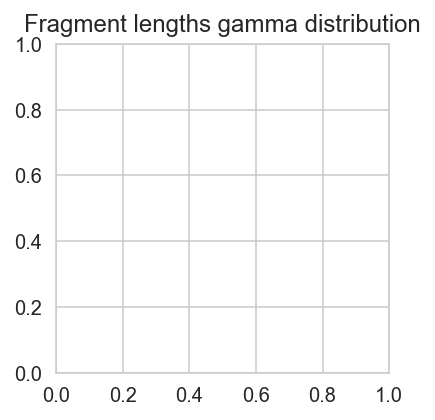

In [551]:
fig = plt.figure(figsize=(3, 3))
sns.scatterplot(data=models_df, x='k', y='theta', hue='Modification', markers=True)
plt.title(f'Fragment lengths gamma distribution')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'models_fragments_gamma.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

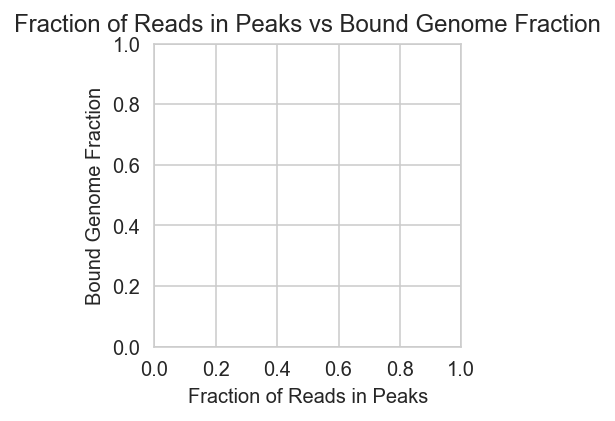

In [552]:
fig = plt.figure(figsize=(3, 3))
sns.scatterplot(data=models_df, x='s', y='f', hue='Modification', markers=True)
plt.title(f'Fraction of Reads in Peaks vs Bound Genome Fraction')
plt.xlabel('Fraction of Reads in Peaks')
plt.ylabel('Bound Genome Fraction')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'models_frip_vs_bound_genome.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

# Report analysis

In [553]:
df = pd.read_csv(os.path.join(WORK_DIR, 'report.tsv'), sep='\t', comment='#')

# Focus on specific tools only
df = df.loc[df['Tool'].isin({'Macs2', 'Macs2Broad', 'SICER', 'SPAN'})]
df['Fdr'] = df['Fdr'].astype(float)
df['Library'] = '1mln'

# Without mixed model
# df = df.loc[df['Modification'] != 'mixed']

# Rename
# df.loc[df['Tool']=='Macs2Broad', 'Tool'] = 'Macs2 broad'

# Remove relaxed FDR setting to avoid explosion in #peaks
# df = df.loc[df['Fdr'] <= 0.05]
df.head()

,Modification,Mult,Library,I,TruePeaksFile,TruePeaks,TrueLength,Tool,PeaksFile,Fdr,Peaks,Length,PrecisionP,RecallP,Intersection
0,H3K27ac,0.5,1mln,1,/Users/Oleg.Shpynov/data/2022_chips_noinput/fa...,500,1025657,Macs2,/Users/Oleg.Shpynov/data/2022_chips_noinput/ma...,0.05,432,362024.0,429,303,358770.0
1,H3K27ac,0.5,1mln,1,/Users/Oleg.Shpynov/data/2022_chips_noinput/fa...,500,1025657,Macs2Broad,/Users/Oleg.Shpynov/data/2022_chips_noinput/ma...,0.05,401,411196.0,395,325,406561.0
2,H3K27ac,0.5,1mln,1,/Users/Oleg.Shpynov/data/2022_chips_noinput/fa...,500,1025657,SICER,/Users/Oleg.Shpynov/data/2022_chips_noinput/si...,0.05,456,1883944.0,386,434,964576.0
3,H3K27ac,0.5,1mln,1,/Users/Oleg.Shpynov/data/2022_chips_noinput/fa...,500,1025657,SPAN,/Users/Oleg.Shpynov/data/2022_chips_noinput/sp...,0.05,365,908800.0,365,399,864161.0
4,H3K27ac,0.3,1mln,1,/Users/Oleg.Shpynov/data/2022_chips_noinput/fa...,500,1025657,Macs2,/Users/Oleg.Shpynov/data/2022_chips_noinput/ma...,0.05,217,125032.0,217,148,124573.0


In [554]:
df.sort_values(by=['Modification', 'Mult', 'Library', 'Tool', 'Fdr'], inplace=True)

In [555]:
df['TrueAverageLength'] = df['TrueLength'] / df['TruePeaks']
df['AverageLength'] = df['Length'] / df['Peaks']
df.fillna(0, inplace=True)

In [556]:
df['LogFdr'] = np.log10(df['Fdr'])
df.loc[df['Fdr']==0.05, 'LogFdr'] = -1.3

In [557]:
df['Precision'] = df['PrecisionP'] / df['Peaks']
df['Recall'] = df['RecallP'] / df['TruePeaks']
df['PrecisionL'] = df['Intersection'] / df['Length']
df['RecallL'] = df['Intersection'] / df['TrueLength']
df.fillna(1, inplace=True)

df['Jaccard'] = df['Intersection'] / (df['Length'] + df['TrueLength'] - df['Intersection'])
df.fillna(0, inplace=True)

In [558]:
# print('Limit peaks number for visual representation')
# df.loc[df['Peaks'] > 2000, 'Peaks'] = 2000
# print('Limit average length for visual representation')
# df.loc[df['AverageLength'] > 15000, 'AverageLength'] = 15000

In [559]:
print('Computing F1-score')
df['F1'] = [2 / (1 / p + 1 / r) if min(p, r) > 0 else 0 for p, r in zip(df['Precision'], df['Recall'])]
df['F1l'] = [2 / (1 / p + 1 / r) if min(p, r) > 0 else 0 for p, r in zip(df['PrecisionL'], df['RecallL'])]
df.head()

Computing F1-score


,Modification,Mult,Library,I,TruePeaksFile,TruePeaks,TrueLength,Tool,PeaksFile,Fdr,...,TrueAverageLength,AverageLength,LogFdr,Precision,Recall,PrecisionL,RecallL,Jaccard,F1,F1l
8,H3K27ac,0.1,1mln,1,/Users/Oleg.Shpynov/data/2022_chips_noinput/fa...,500,1025657,Macs2,/Users/Oleg.Shpynov/data/2022_chips_noinput/ma...,0.05,...,2051.314,0.0,-1.3,1.0,0.0,1.0,0.0,0.0,0.0,0.0
20,H3K27ac,0.1,1mln,2,/Users/Oleg.Shpynov/data/2022_chips_noinput/fa...,500,981545,Macs2,/Users/Oleg.Shpynov/data/2022_chips_noinput/ma...,0.05,...,1963.090,0.0,-1.3,1.0,0.0,1.0,0.0,0.0,0.0,0.0
32,H3K27ac,0.1,1mln,3,/Users/Oleg.Shpynov/data/2022_chips_noinput/fa...,500,1051662,Macs2,/Users/Oleg.Shpynov/data/2022_chips_noinput/ma...,0.05,...,2103.324,0.0,-1.3,1.0,0.0,1.0,0.0,0.0,0.0,0.0
44,H3K27ac,0.1,1mln,4,/Users/Oleg.Shpynov/data/2022_chips_noinput/fa...,500,1053954,Macs2,/Users/Oleg.Shpynov/data/2022_chips_noinput/ma...,0.05,...,2107.908,0.0,-1.3,1.0,0.0,1.0,0.0,0.0,0.0,0.0
56,H3K27ac,0.1,1mln,5,/Users/Oleg.Shpynov/data/2022_chips_noinput/fa...,500,1046384,Macs2,/Users/Oleg.Shpynov/data/2022_chips_noinput/ma...,0.05,...,2092.768,0.0,-1.3,1.0,0.0,1.0,0.0,0.0,0.0,0.0


# Summary number of peaks

Ground truth average number of peaks


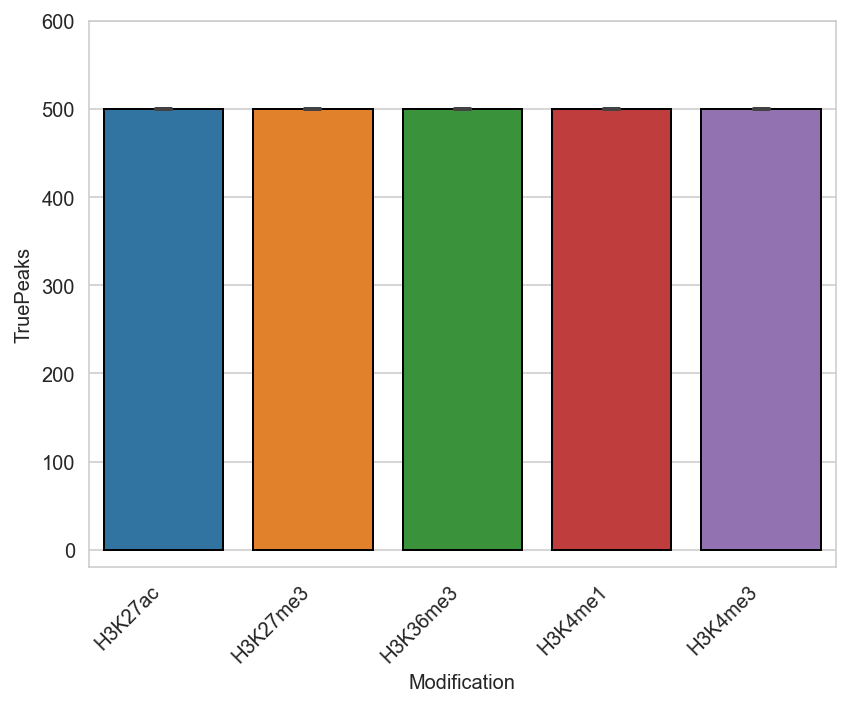

In [560]:
print('Ground truth average number of peaks')
fig = plt.figure(figsize=(6, 5))
sns.barplot(data=df, x="Modification", y="TruePeaks",
           capsize=.1, errwidth=2, edgecolor="black")
plt.xticks(rotation=45, ha='right')
plt.ylim(-20, df['TruePeaks'].max() * 1.2)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'true_peaks_number.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()        

Ground truth average length of peaks


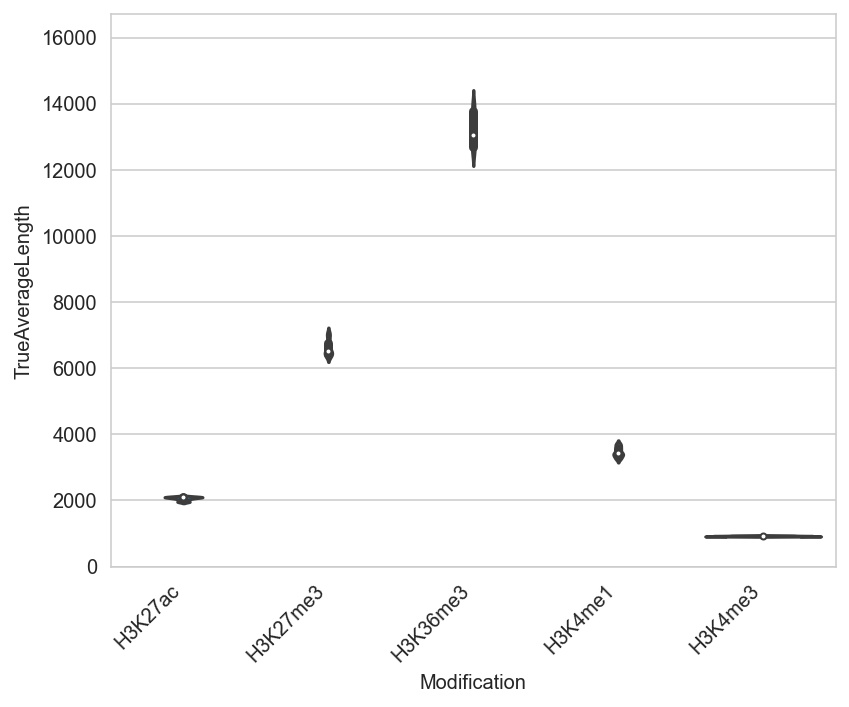

In [561]:
print('Ground truth average length of peaks')
fig = plt.figure(figsize=(6, 5))
# sns.barplot(data=df, x="Modification", y="TrueAverageLength", 
#            capsize=.2, errwidth=2, edgecolor="black")
sns.violinplot(data=df, x="Modification", y="TrueAverageLength")
plt.xticks(rotation=45, ha='right')
plt.ylim(-20, df['TrueAverageLength'].max() * 1.2)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'true_peaks_lengths.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

In [562]:
cmap = plt.cm.get_cmap('Pastel1', len(set(df['Tool'])))
palette = {t: cmap(i) for i, t in enumerate(sorted(set(df['Tool'])))}

In [563]:
def summary_peaks_lengths(df, name):
    for m in sorted(set(df['Modification'])):
        t = df.loc[df['Modification'] == m].copy()
        t.sort_values(by=['Tool', 'Fdr'], inplace=True)

        fig = plt.figure(figsize=(15, 5))
        ax = plt.subplot(1, 2, 1)
        print('Peaks', m)
        print(f"True peaks {set(t['TruePeaks'])}")
        sns.boxplot(data=t, x="Fdr", y="Peaks", hue="Tool", palette=palette)
        plt.title(f'{m} {name}')
        plt.xticks(rotation=45, ha='right')
        plt.legend(loc='upper left')
        plt.ylim(-20, t['Peaks'].max() * 1.2)

        ax = plt.subplot(1, 2, 2)            
        print('Length', m)
        print(f"True average length {set(t['TrueAverageLength'])}")        
        sns.boxplot(data=t, x="Fdr", y="AverageLength", hue="Tool", palette=palette)
        plt.title(f'{m} {name}')
        plt.xticks(rotation=45, ha='right')
        plt.legend(loc='upper left')
        plt.ylim(-20, t['AverageLength'].max() * 1.2)

        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, f'summary_peaks_length_{name}_{m}.{EXT}'), bbox_inches='tight', dpi=300)
        plt.show()        

In [564]:
from itertools import product

CONDITIONS = [('1mln', 1.0), ('1mln', 0.5),  ('1mln', 0.3),  ('1mln', 0.1), ('1mln', 0.05)]

def perfect(df):
    return df['Mult'] == 1.0

def good(df):
    return df['Mult'] == 0.5

def average(df):
    return df['Mult'] == 0.3

def bad(df):
    return df['Mult'] == 0.1

def ugly(df):
    return df['Mult'] == 0.05


def with_quality(df, add_all=False):
    ts = []

    t = df.loc[perfect(df)].copy()
    t['Quality'] = 'Perfect'
    ts.append(t)

    t = df.loc[good(df)].copy()
    t['Quality'] = 'Good'
    ts.append(t)

    t = df.loc[average(df)].copy()
    t['Quality'] = 'Average'
    ts.append(t)

    t = df.loc[bad(df)].copy()
    t['Quality'] = 'Bad'
    ts.append(t)

    t = df.loc[ugly(df)].copy()
    t['Quality'] = 'Ugly'
    ts.append(t)

    if add_all:
        t = df.copy()
        t['Quality'] = 'All'
        ts.append(t)
    return pd.concat(ts)

In [565]:
# # Supplementary
# print('Summary number of peaks and length good quality')
# summary_peaks_lengths(df.loc[good(df)], 'good')

In [566]:
# # Supplementary
# print('Summary number of peaks and length on average quality')
# summary_peaks_lengths(df.loc[average(df)], 'average')

In [567]:
# # Supplementary
# print('Summary number of peaks and length on bad quality')
# summary_peaks_lengths(df.loc[bad(df)], 'bad')

## Aggregated results

In [568]:
def aggregated_info_fdr(df, fdr=None):
    if fdr is not None:
        df = df.loc[df['Fdr'] == fdr]
    df = with_quality(df)
    
    for q in sorted(set(df['Quality'])):
        t = df.loc[df['Quality'] == q].copy()
        t.sort_values(by=['Modification', 'Tool', 'Fdr'], inplace=True)

        fig = plt.figure(figsize=(6, 4))
        print('Peaks', q)
        print(f"True peaks {set(t['TruePeaks'])}")
        sns.barplot(data=t, x="Modification", y="Peaks", hue="Tool", palette=palette, 
                    capsize=.1, errwidth=2, edgecolor="black")
        plt.title(f'Number of peaks {q} fdr={fdr}')
        plt.xticks(rotation=45, ha='right')
        plt.legend(loc='upper left')
        plt.ylim(-20, t['Peaks'].max() * 1.2)
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, f'aggregated_peaks_{q}_fdr{fdr}.{EXT}'), bbox_inches='tight', dpi=300)
        plt.show() 

        fig = plt.figure(figsize=(6, 4))
        print('Length', q)
        print(f"True average length {set(t['TrueAverageLength'])}")        
        sns.barplot(data=t, x="Modification", y="AverageLength", hue="Tool", palette=palette,
                   capsize=.1, errwidth=2, edgecolor="black")
        plt.title(f'Average length {q} fdr={fdr}')
        plt.xticks(rotation=45, ha='right')
        plt.legend(loc='lower left')
        plt.ylim(-20, t['AverageLength'].max() * 1.2)
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, f'aggregated_lengths_{q}_fdr{fdr}.{EXT}'), bbox_inches='tight', dpi=300)
        plt.show()         

        fig = plt.figure(figsize=(6, 4))
        print('Jaccard', q)
        sns.barplot(data=t, x="Modification", y="Jaccard", hue="Tool", palette=palette,
                   capsize=.1, errwidth=2, edgecolor="black")
        plt.title(f'Jaccard {q} fdr={fdr}')
        plt.xticks(rotation=45, ha='right')
        plt.legend(loc='lower left')
        plt.ylim(-0.1, t['Jaccard'].max() * 1.2)
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, f'jaccard_{q}_fdr{fdr}.{EXT}'), bbox_inches='tight', dpi=300)
        plt.show()        

        print('Overlap')

        fig = plt.figure(figsize=(6, 4))
        print('Precision', q)
        sns.barplot(data=t, x="Modification", y="Precision", hue="Tool", palette=palette,
                   capsize=.1, errwidth=2, edgecolor="black")
        plt.title(f'Precision {q} fdr={fdr}')
        plt.xticks(rotation=45, ha='right')
        plt.legend(loc='lower left')
        plt.ylim(-0.1, t['Precision'].max() * 1.2)
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, f'precision_{q}_fdr{fdr}.{EXT}'), bbox_inches='tight', dpi=300)
        plt.show()

        fig = plt.figure(figsize=(6, 4))
        print('Recall', q)
        sns.barplot(data=t, x="Modification", y="Recall", hue="Tool", palette=palette,
                   capsize=.1, errwidth=2, edgecolor="black")
        plt.title(f'Recall {q} fdr={fdr}')
        plt.xticks(rotation=45, ha='right')
        plt.legend(loc='lower left')
        plt.ylim(-0.1, t['Recall'].max() * 1.2)
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, f'recall_{q}_fdr{fdr}.{EXT}'), bbox_inches='tight', dpi=300)
        plt.show()

        fig = plt.figure(figsize=(6, 4))
        print('F1', q)
        sns.barplot(data=t, x="Modification", y="F1", hue="Tool", palette=palette,
                   capsize=.1, errwidth=2, edgecolor="black")
        plt.title(f'F1 {q} fdr={fdr}')
        plt.xticks(rotation=45, ha='right')
        plt.legend(loc='lower left')
        plt.ylim(-0.1, t['F1'].max() * 1.2)
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, f'f1_{q}_fdr{fdr}.{EXT}'), bbox_inches='tight', dpi=300)
        plt.show()

        print('Overlap')

        fig = plt.figure(figsize=(6, 4))
        print('PrecisionL', q)
        sns.barplot(data=t, x="Modification", y="PrecisionL", hue="Tool", palette=palette,
                   capsize=.1, errwidth=2, edgecolor="black")
        plt.title(f'Precision {q} fdr={fdr}')
        plt.xticks(rotation=45, ha='right')
        plt.legend(loc='lower left')
        plt.ylim(-0.1, t['Precision'].max() * 1.2)
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, f'precisionl_{q}_fdr{fdr}.{EXT}'), bbox_inches='tight', dpi=300)
        plt.show()        
        
        fig = plt.figure(figsize=(6, 4))
        print('RecallL', q)
        sns.barplot(data=t, x="Modification", y="RecallL", hue="Tool", palette=palette,
                   capsize=.1, errwidth=2, edgecolor="black")
        plt.title(f'Recall {q} fdr={fdr}')
        plt.xticks(rotation=45, ha='right')
        plt.legend(loc='lower left')
        plt.ylim(-0.1, t['Recall'].max() * 1.2)
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, f'recalll_{q}_fdr{fdr}.{EXT}'), bbox_inches='tight', dpi=300)
        plt.show()                

        fig = plt.figure(figsize=(6, 4))
        print('F1l', q)
        sns.barplot(data=t, x="Modification", y="F1l", hue="Tool", palette=palette,
                   capsize=.1, errwidth=2, edgecolor="black")
        plt.title(f'F1l {q} fdr={fdr}')
        plt.xticks(rotation=45, ha='right')
        plt.legend(loc='lower left')
        plt.ylim(-0.1, t['F1'].max() * 1.2)
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, f'f1l_{q}_fdr{fdr}.{EXT}'), bbox_inches='tight', dpi=300)
        plt.show()

In [569]:
aggregated_info_fdr(df[perfect(df)])

Peaks Good
True peaks {500}


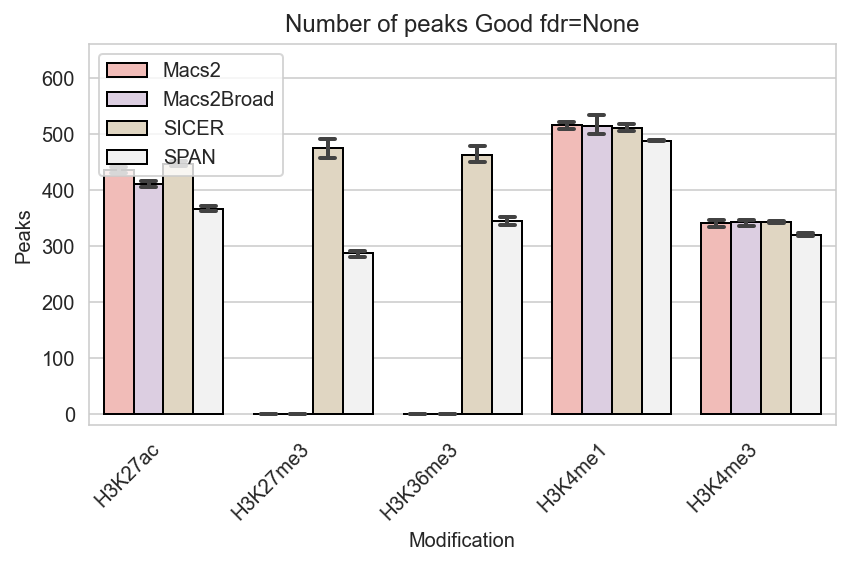

Length Good
True average length {2051.314, 12677.0, 6534.6, 912.56, 912.358, 926.156, 932.096, 6437.0, 6394.6, 1963.09, 2092.768, 943.708, 3381.98, 2103.324, 12603.8, 2107.908, 3276.482, 13781.0, 3424.588, 13923.8, 6761.4, 3563.93, 3691.36, 7022.2, 13050.6}


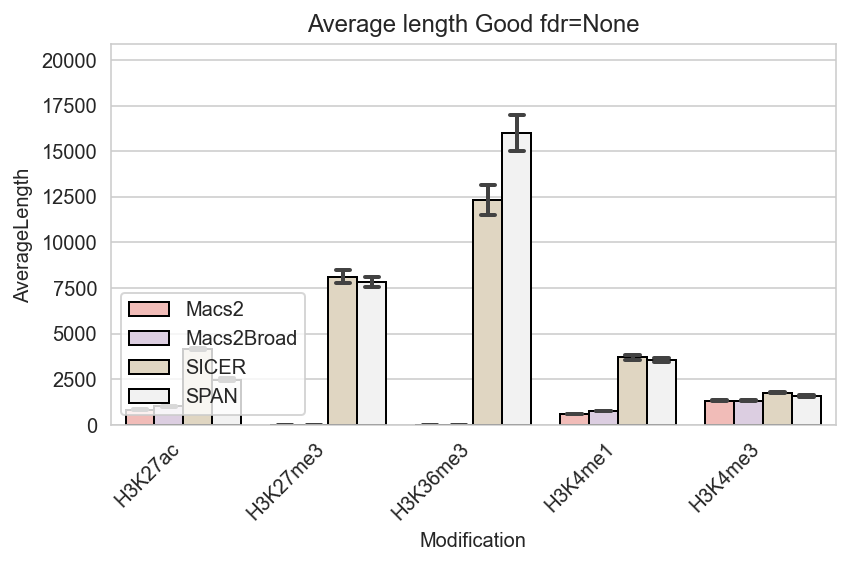

Jaccard Good


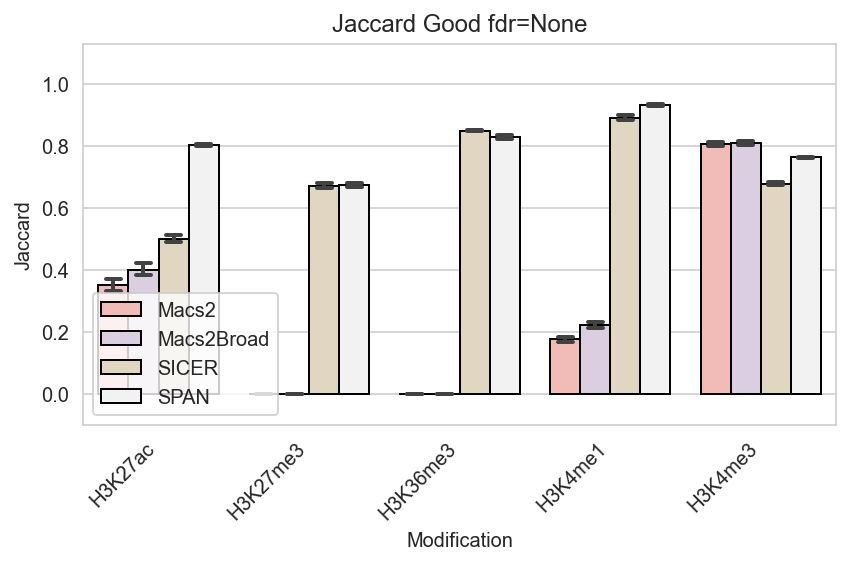

Overlap
Precision Good


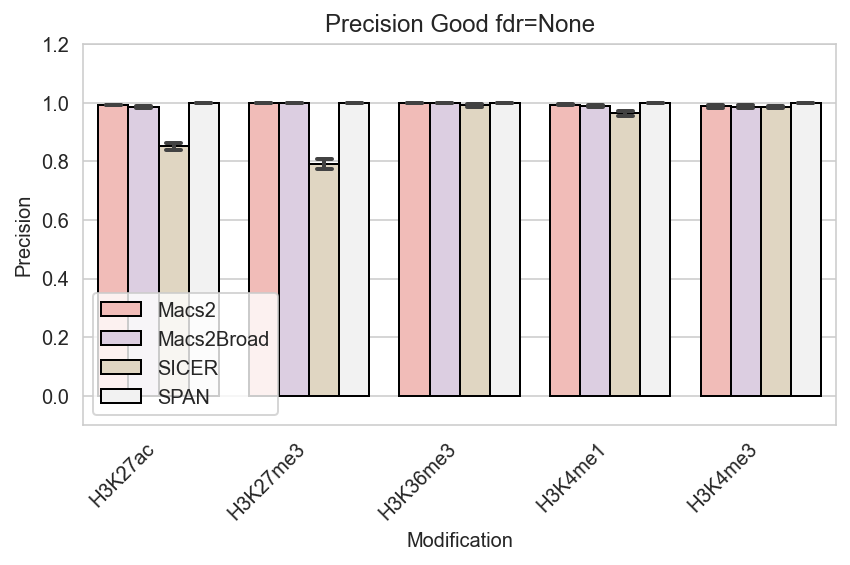

Recall Good


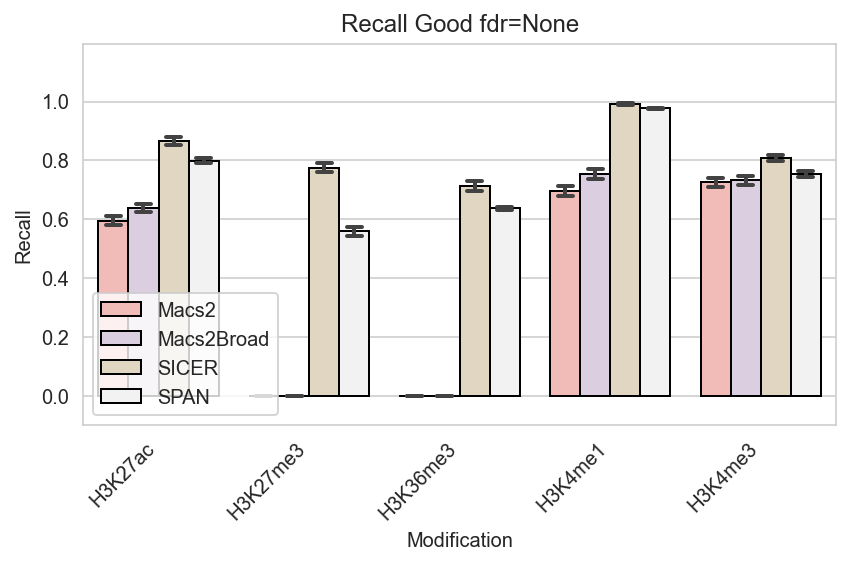

F1 Good


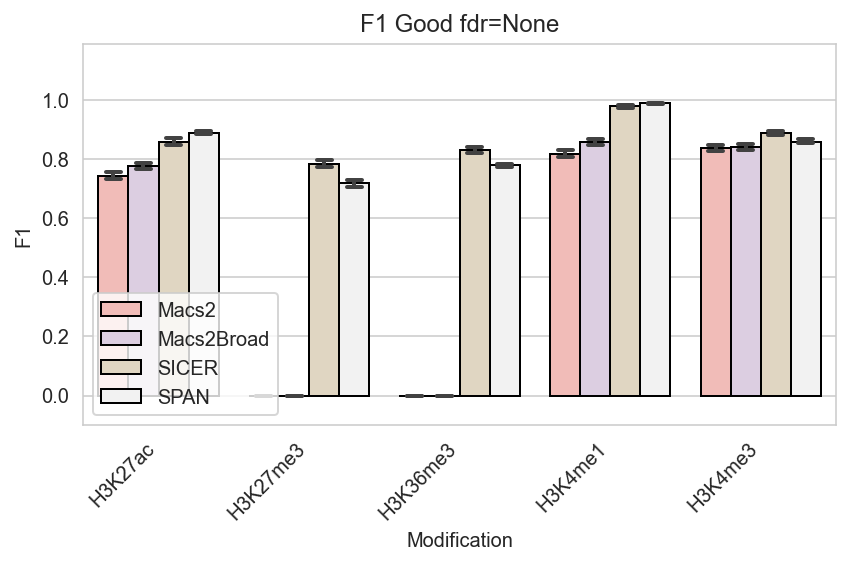

Overlap
PrecisionL Good


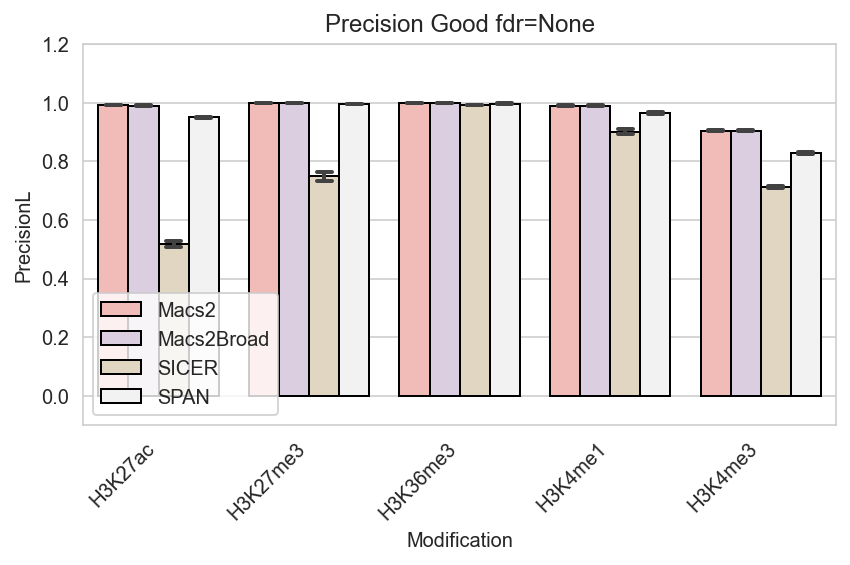

RecallL Good


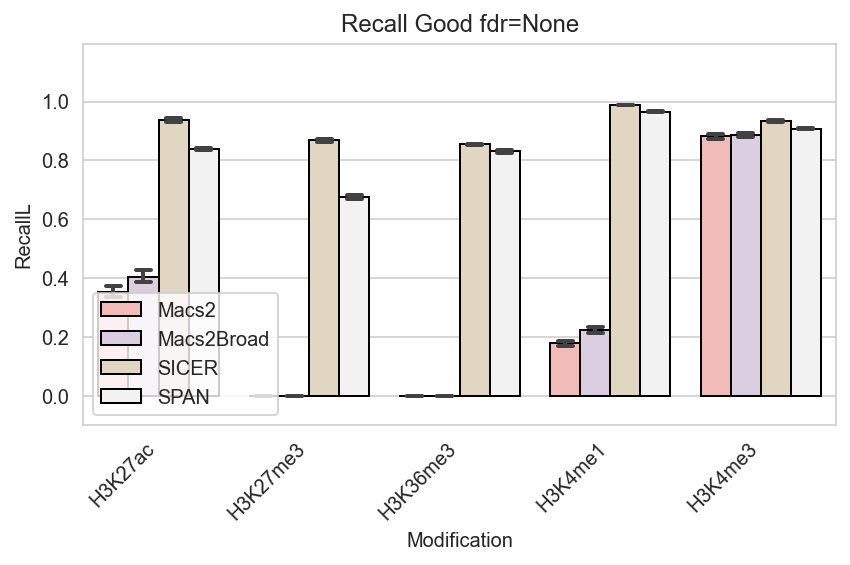

F1l Good


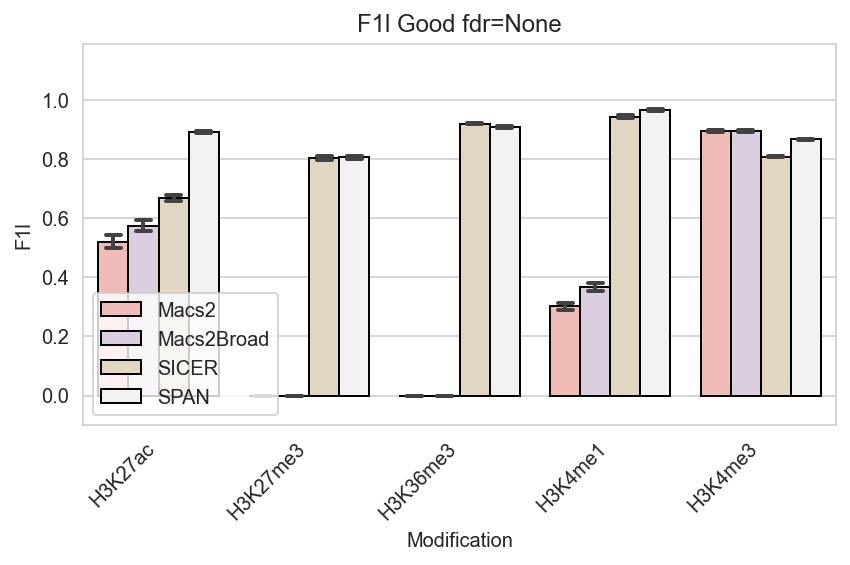

In [570]:
aggregated_info_fdr(df[good(df)])

Peaks Average
True peaks {500}


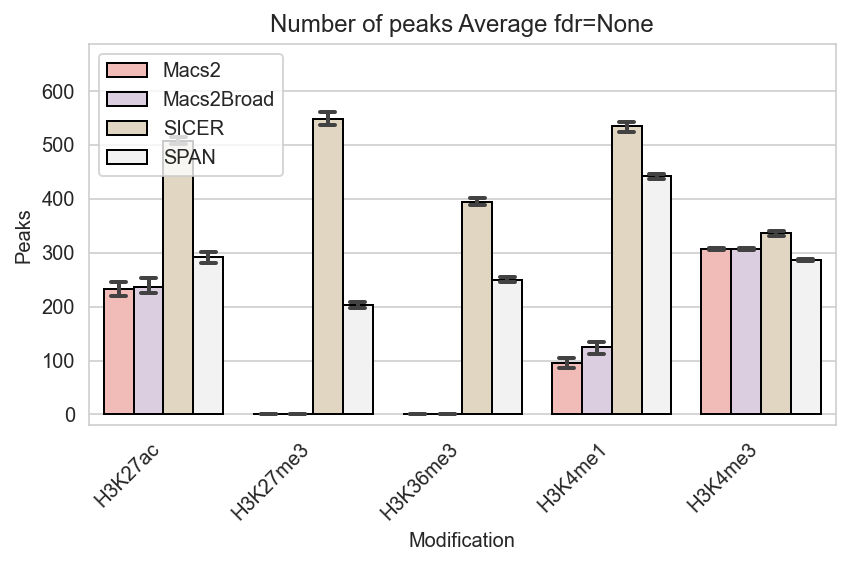

Length Average
True average length {2051.314, 12677.0, 6534.6, 912.56, 912.358, 926.156, 932.096, 6437.0, 6394.6, 1963.09, 2092.768, 943.708, 3381.98, 2103.324, 12603.8, 2107.908, 3276.482, 13781.0, 3424.588, 13923.8, 6761.4, 3563.93, 3691.36, 7022.2, 13050.6}


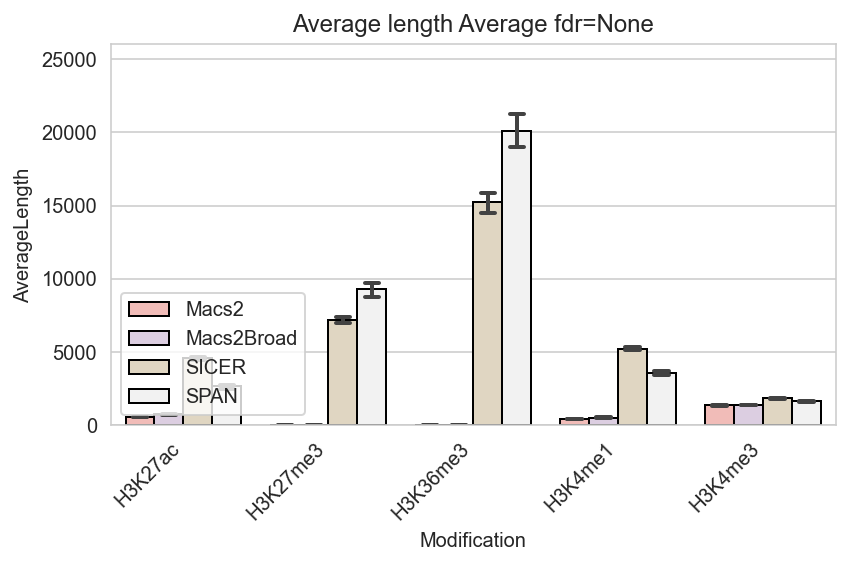

Jaccard Average


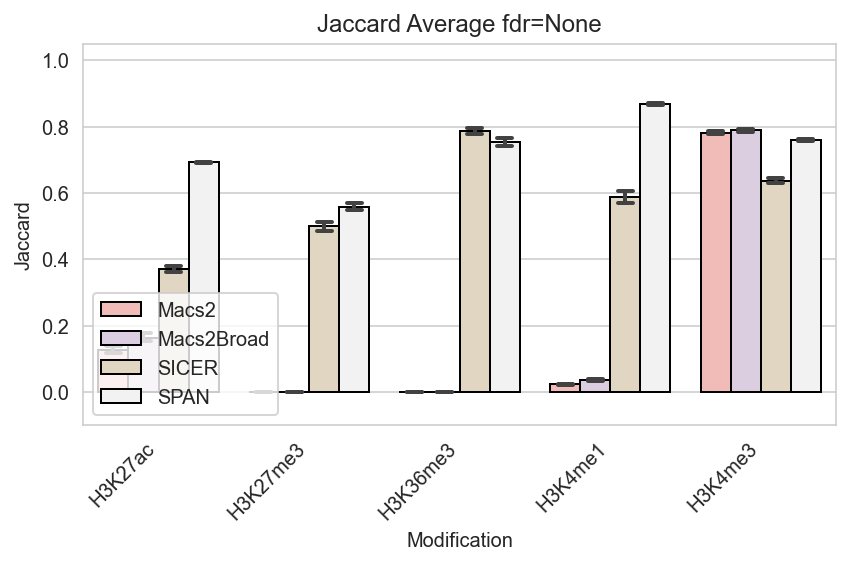

Overlap
Precision Average


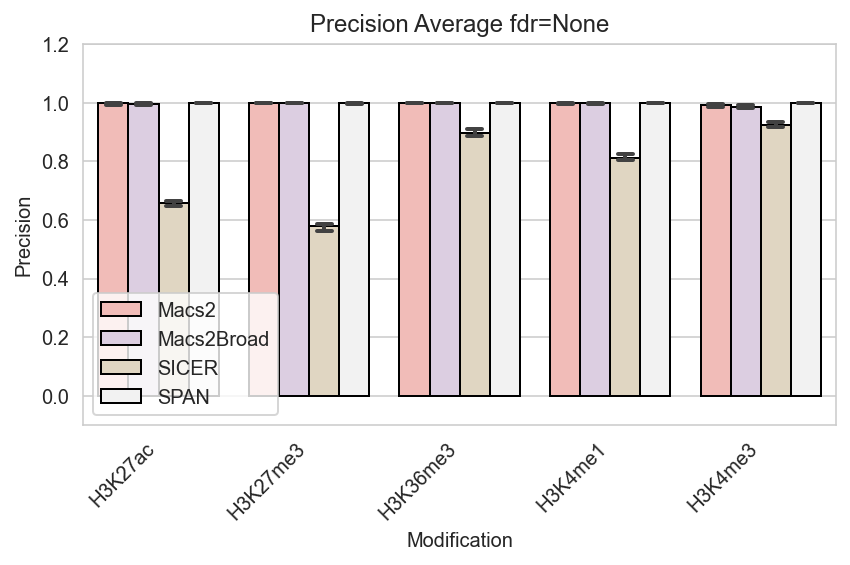

Recall Average


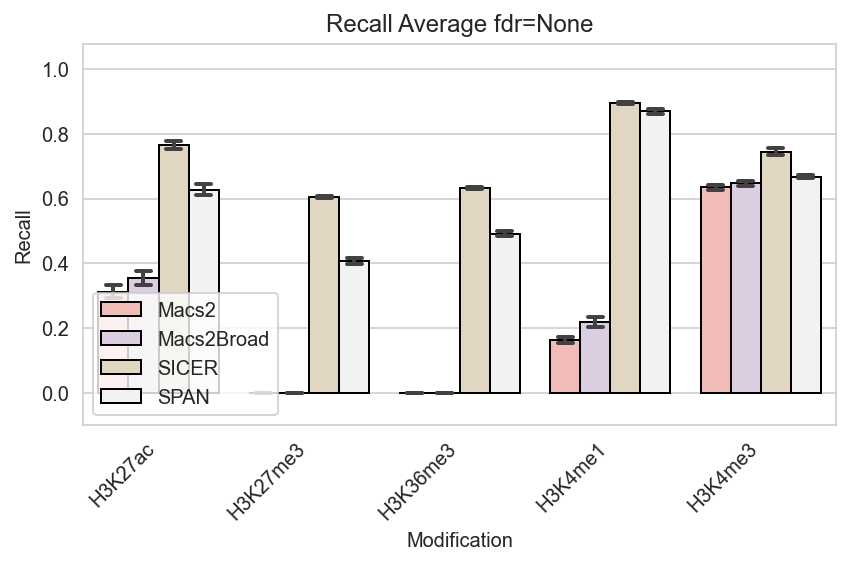

F1 Average


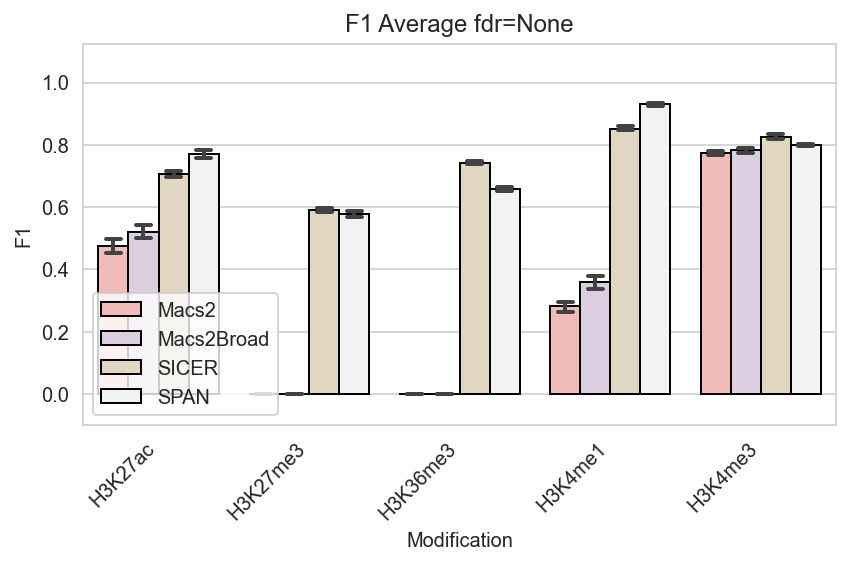

Overlap
PrecisionL Average


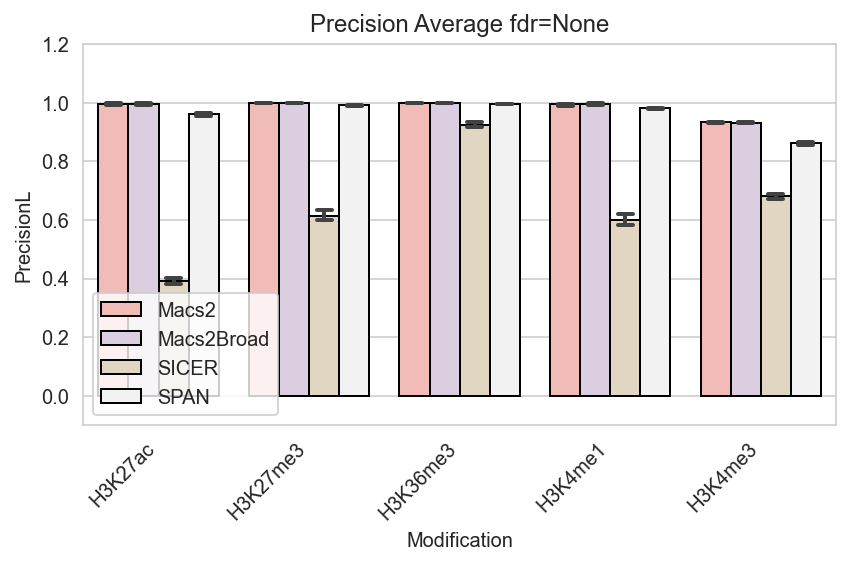

RecallL Average


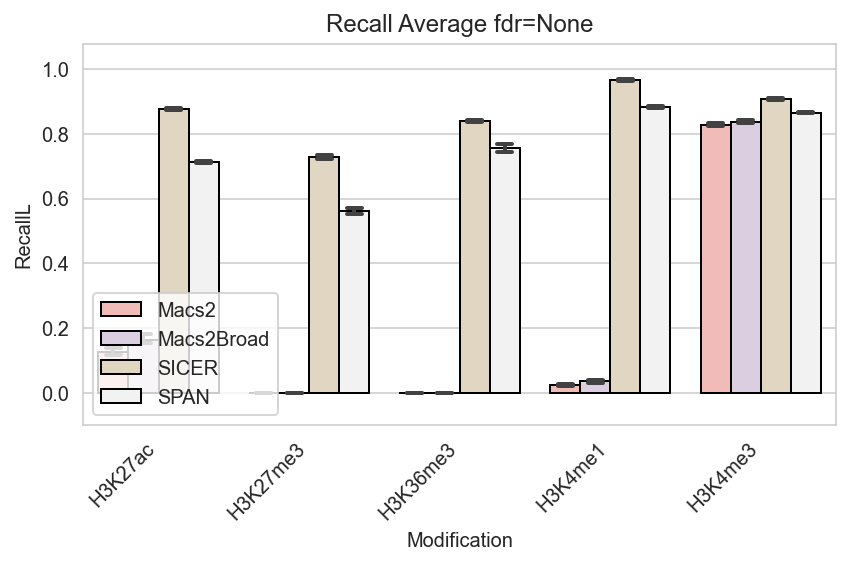

F1l Average


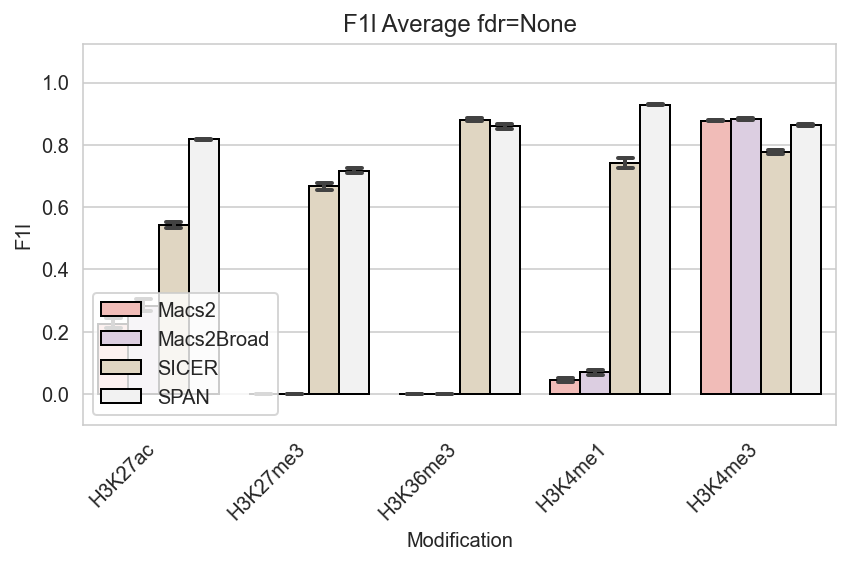

In [571]:
aggregated_info_fdr(df[average(df)])

Peaks Bad
True peaks {500}


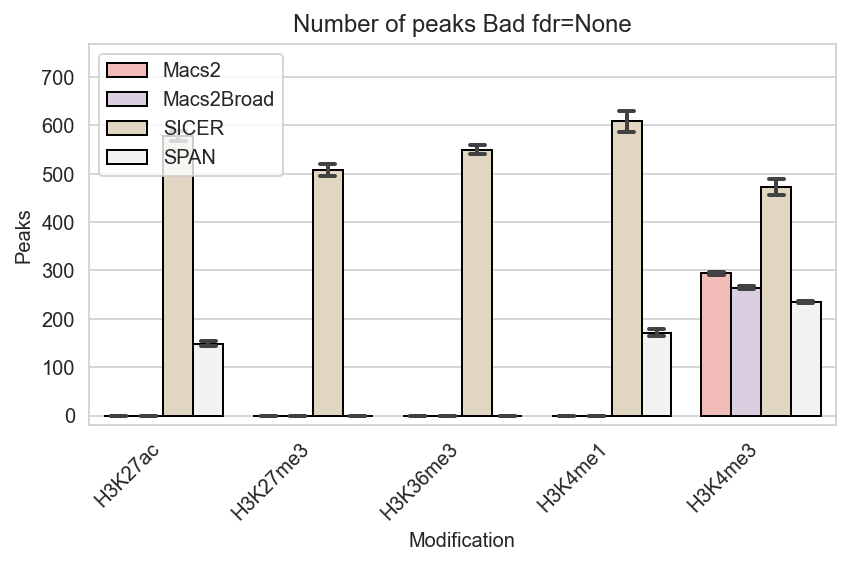

Length Bad
True average length {2051.314, 12677.0, 6534.6, 912.56, 912.358, 926.156, 932.096, 6437.0, 6394.6, 1963.09, 2092.768, 943.708, 3381.98, 2103.324, 12603.8, 2107.908, 3276.482, 13781.0, 3424.588, 13923.8, 6761.4, 3563.93, 3691.36, 7022.2, 13050.6}


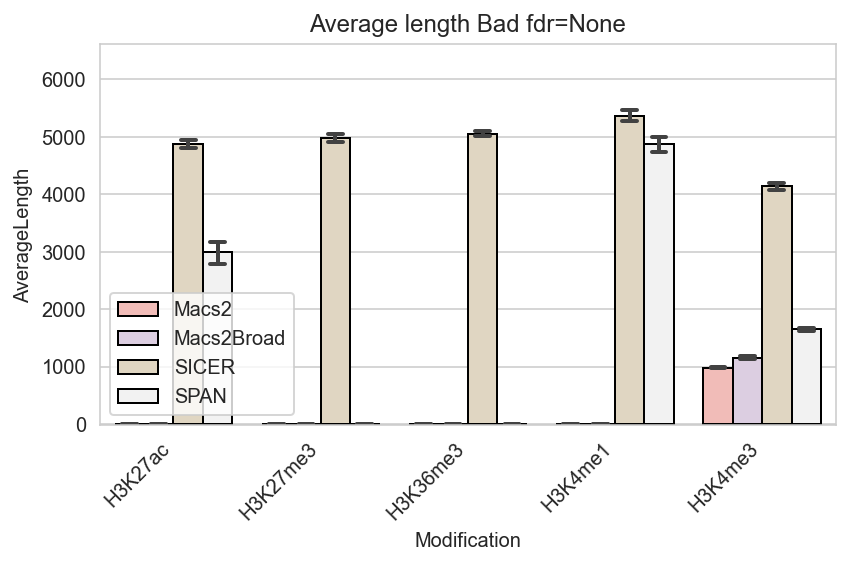

Jaccard Bad


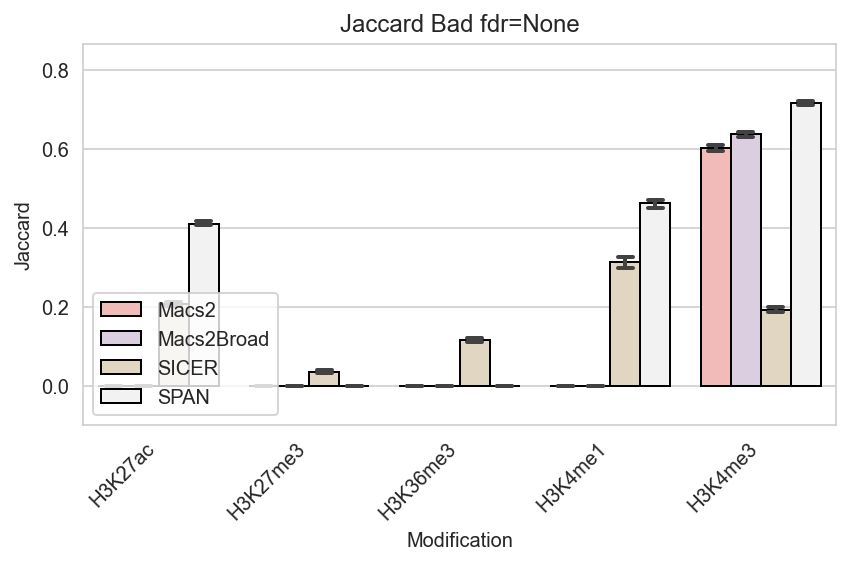

Overlap
Precision Bad


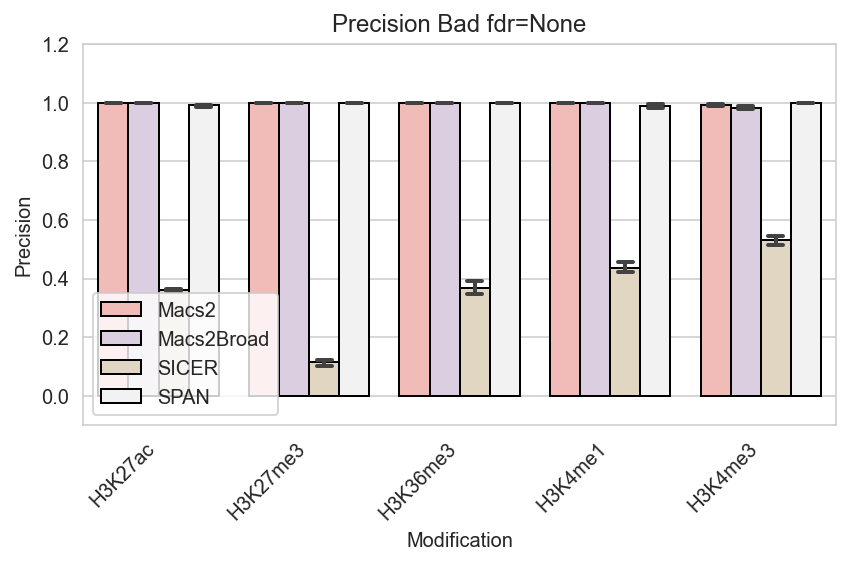

Recall Bad


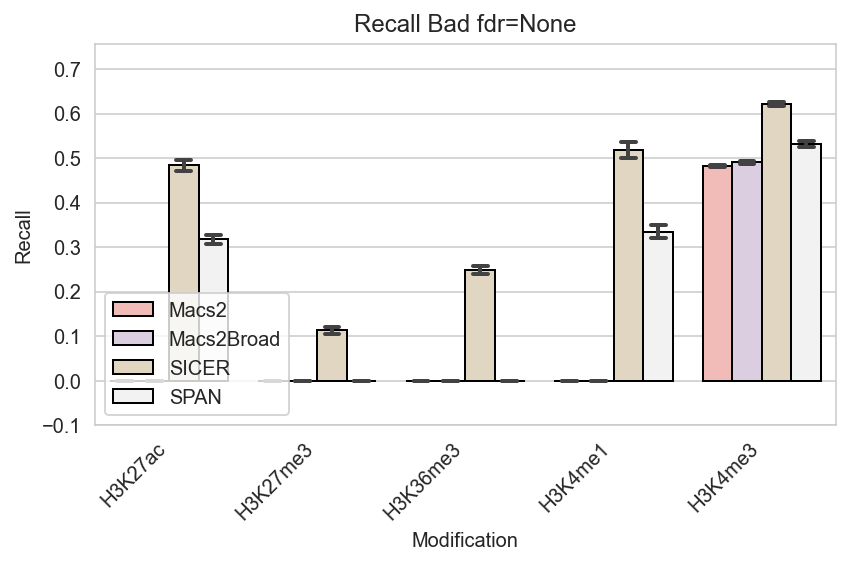

F1 Bad


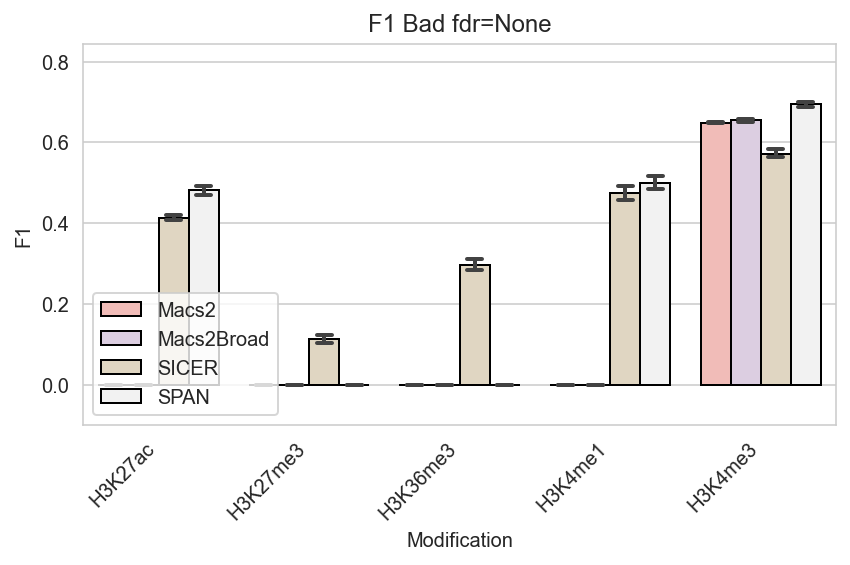

Overlap
PrecisionL Bad


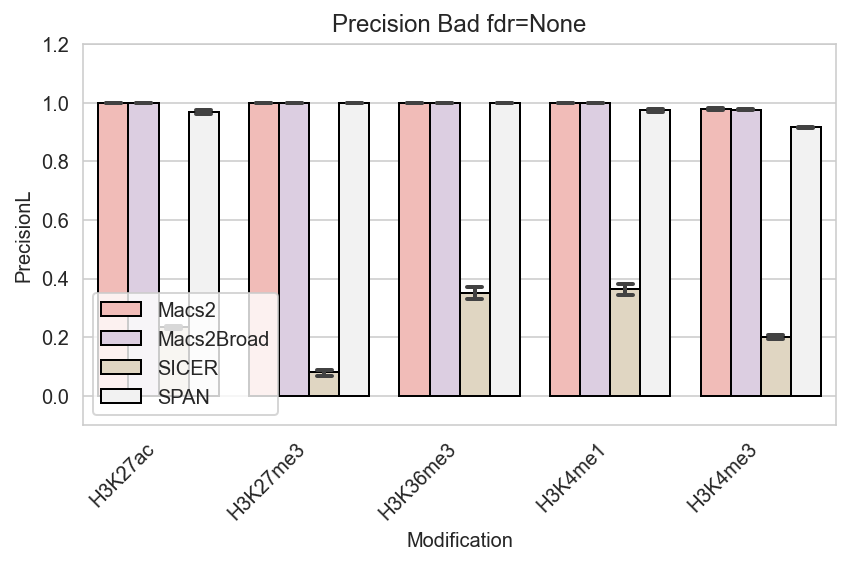

RecallL Bad


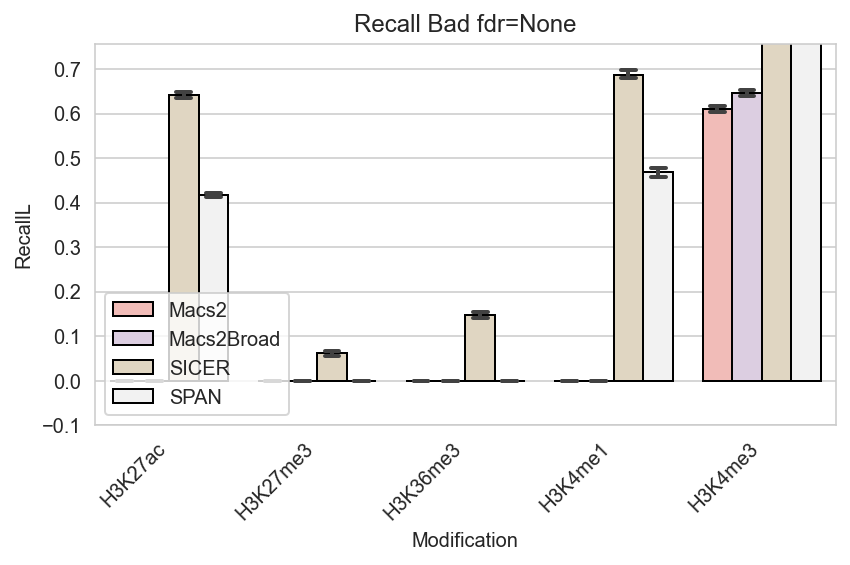

F1l Bad


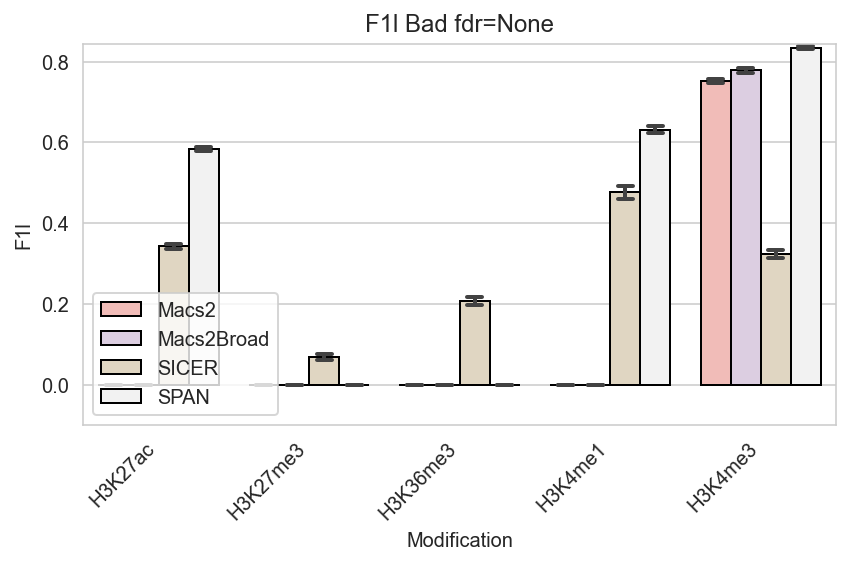

In [572]:
aggregated_info_fdr(df[bad(df)])

In [573]:
aggregated_info_fdr(df[ugly(df)])

In [574]:
def aggregated_peaks_lengths(df):
    df = with_quality(df)
    
    for q in sorted(set(df['Quality'])):
        t = df.loc[df['Quality'] == q].copy()
        t.sort_values(by=['Modification', 'Tool', 'Fdr'], inplace=True)

        fig = plt.figure(figsize=(12, 4))
        print('Peaks', q)
        print(f"True peaks {set(t['TruePeaks'])}")
        # Aesthetics
        t["Peaks"].clip(upper=1000, inplace=True)
        sns.catplot(data=t, x="Tool", y="Peaks", hue="Fdr", col="Modification", 
                    kind="box", aspect=.6, palette='mako')
        plt.ylim(bottom=0)
        plt.savefig(os.path.join(FIGURES_DIR, f'aggregated_peaks_{q}.{EXT}'))
        plt.show() 

        fig = plt.figure(figsize=(12, 4))
        print('Length', q)
        print(f"True average length {set(t['TrueAverageLength'])}")        
        sns.catplot(data=t, x="Tool", y="AverageLength", hue="Fdr", col="Modification", 
                    kind="box", aspect=.6, palette='mako')

        plt.savefig(os.path.join(FIGURES_DIR, f'aggregated_length_{q}.{EXT}'))
        plt.show()        

In [575]:
# Supplementary
# aggregated_peaks_lengths(df)

## Peaks vs Average length

In [576]:
def summary_vs(df, name, v1, v2):
    for m in sorted(set(df['Modification'])):
        print(m)
        t = df.loc[df['Modification'] == m]
        fig = plt.figure(figsize=(12, 6))
        for (lib, mult) in CONDITIONS:
            for i in set(t['I']):
                for tool in set(t['Tool']):
                    tt = t.loc[(df['Mult'] == mult) & (t['Library'] == lib) & (t['I'] == i)].copy()
                    tt.sort_values(by=['Tool', 'Fdr'], inplace=True)
                    sns.lineplot(data=tt, x=v1, y=v2, hue='Tool', 
                                 markers=True, style='I', palette=palette, alpha=0.8)
#             plt.ylim(-20, t['AverageLength'].max() * 1.2)
        # Single legend
        handles, labels = plt.axes().get_legend_handles_labels()
        plt.legend(handles=handles[:len(set(t['Tool'])) + 1], 
                   labels=labels[:len(set(t['Tool'])) + 1],
                  loc='lower left')
        plt.title(f'{m} {name}')
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, f'summary_{v1}_vs_{v2}_{m}_{name}.{EXT}'), bbox_inches='tight', dpi=300)
        plt.show()

In [577]:
# Supplementary
# print('Peaks vs Average Length')
# summary_vs(df.loc[good(df)], 'good_quality', 'Peaks', 'AverageLength')

In [578]:
from math import ceil, floor

def peaks_lengths(df):
    for m in sorted(set(df['Modification'])):
        print('Peaks', m)
        print(f"True peaks {set(df[df['Modification'] == m]['TruePeaks'])}")
        nrows = int(floor(len(CONDITIONS) / 3))
        ncols = int(ceil(len(CONDITIONS) / nrows))
        fig = plt.figure(figsize=(5 * ncols, 5 * nrows))        
        for i, (lib, mult) in enumerate(CONDITIONS):
            t = df.loc[(df['Modification'] == m) & (df['Mult'] == mult) & (df['Library'] == lib)]
            ax = plt.subplot(nrows, ncols, i + 1)
            sns.boxplot(data=t, x="Fdr", y="Peaks", hue="Tool", palette=palette)
            plt.title(f'{m} {lib} {mult}')
            plt.xticks(rotation=45, ha='right')
            plt.ylim(-20, t['Peaks'].max() * 1.2)
            if i % nrows == 0:
                ax.legend(loc='upper left')
            else:
                ax.get_legend().remove()    

        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, f'peaks_{m}.{EXT}'), bbox_inches='tight', dpi=300)
        plt.show()

        print('Length', m)
        print(f"True average length {set(df[df['Modification'] == m]['TrueAverageLength'])}")        
        nrows = int(floor(len(CONDITIONS) / 3))
        ncols = int(ceil(len(CONDITIONS) / nrows))
        fig = plt.figure(figsize=(5 * ncols, 5 * nrows))        
        for i, (lib, mult) in enumerate(CONDITIONS):
            t = df.loc[(df['Modification'] == m) & (df['Mult'] == mult) & (df['Library'] == lib)]
            ax = plt.subplot(nrows, ncols, i + 1)
            sns.boxplot(data=t, x="Fdr", y="AverageLength", hue="Tool", palette=palette)
            plt.title(f'{m} {lib} {mult}')
            plt.xticks(rotation=45, ha='right')
            plt.ylim(-20, t['AverageLength'].max() * 1.2)
            if i % nrows == 0:
                ax.legend(loc='upper left')
            else:
                ax.get_legend().remove()    

        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, f'length_{m}.{EXT}'), bbox_inches='tight', dpi=300)
        plt.show()        

In [579]:
# Supplementary
print('Summary number of peaks and length')
# peaks_lengths(df)

Summary number of peaks and length


## Precision / Recall

In [580]:
def precision_recall_detailed(df):
    for m in sorted(set(df['Modification'])):
        print(m)
        nrows = int(floor(len(CONDITIONS) / 3))
        ncols = int(ceil(len(CONDITIONS) / nrows))
        fig = plt.figure(figsize=(5 * ncols, 5 * nrows))        
        for i, (lib, mult) in enumerate(CONDITIONS):
            t = df.loc[(df['Modification'] == m) & (df['Mult'] == mult) & (df['Library'] == lib)]
            ax = plt.subplot(nrows, ncols, i + 1)
            for I in set(t['I']):
                tt = t.loc[t['I'] == I].copy()
                tt.sort_values(by=['Tool', 'Recall', 'Precision'], inplace=True)
                sns.lineplot(data=tt, x='Recall', y='Precision', hue='Tool', 
                             markers=True, style='I', alpha=0.8)
            if i % nrows == 0:
                # Single legend
                handles, labels = ax.get_legend_handles_labels()
                ax.legend(handles=handles[:len(set(tt['Tool'])) + 1], 
                          labels=labels[:len(set(tt['Tool'])) + 1],
                         loc='lower left')
            else:
                ax.get_legend().remove()

            plt.xlim(-0.1, 1.1)
            plt.ylim(-0.1, 1.1)
            plt.title(f'{m} {lib} {mult}')
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, f'prc_plot_{m}.{EXT}'), bbox_inches='tight', dpi=300)
        plt.show()

In [581]:
# # Supplementary
# print('Detailed Precision / Recall plot')
# precision_recall_detailed(df)

In [582]:
def precision_recall_length_detailed(df):
    for m in sorted(set(df['Modification'])):
        print(m)
        nrows = int(floor(len(CONDITIONS) / 3))
        ncols = int(ceil(len(CONDITIONS) / nrows))
        fig = plt.figure(figsize=(5 * ncols, 5 * nrows))        
        for i, (lib, mult) in enumerate(CONDITIONS):
            t = df.loc[(df['Modification'] == m) & (df['Mult'] == mult) & (df['Library'] == lib)]
            ax = plt.subplot(nrows, ncols, i + 1)
            for I in set(t['I']):
                tt = t.loc[t['I'] == I].copy()
                tt.sort_values(by=['Tool', 'RecallL', 'PrecisionL'], inplace=True)
                sns.lineplot(data=tt, x='RecallL', y='PrecisionL', hue='Tool', 
                             markers=True, style='I', alpha=0.8)
            if i % nrows == 0:
                # Single legend
                handles, labels = ax.get_legend_handles_labels()
                ax.legend(handles=handles[:len(set(tt['Tool'])) + 1], 
                          labels=labels[:len(set(tt['Tool'])) + 1],
                         loc='lower left')
            else:
                ax.get_legend().remove()

            plt.xlim(-0.1, 1.1)
            plt.ylim(-0.1, 1.1)
            plt.title(f'{m} {lib} {mult}')
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, f'prc_plot_{m}.{EXT}'), bbox_inches='tight', dpi=300)
        plt.show()

Detailed Precision / Recall plot
H3K27ac


UnboundLocalError: local variable 'tt' referenced before assignment

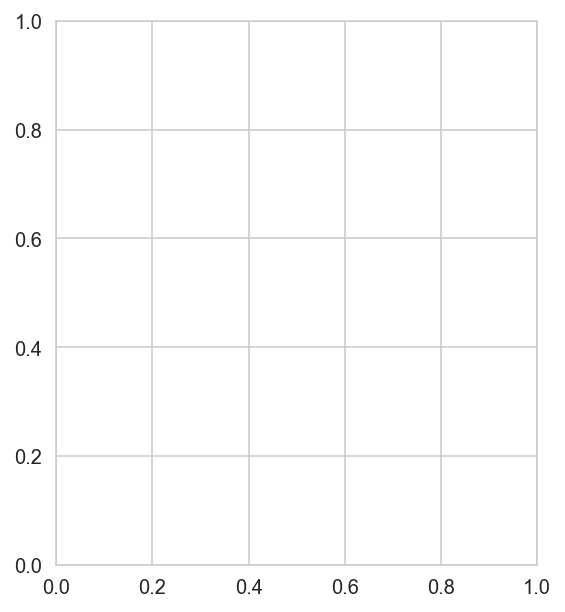

In [583]:
# Supplementary
print('Detailed Precision / Recall plot')
precision_recall_length_detailed(df)

## Aggregated precision / recall

In [ ]:
def aggregated_precision_recall(df, name):
    print('Peaks', name)
    fig = plt.figure(figsize=(18, 3))
    for i, m in enumerate(sorted(set(df['Modification']))):
        ax = plt.subplot(1, len(set(df['Modification'])), i+1)
        tt = df.loc[df['Modification'] == m]
        for (lib, mult) in CONDITIONS:
            for I in set(tt['I']):
                for tool in set(tt['Tool']):
                    ttt = tt.loc[(tt['Mult'] == mult) & (tt['Library'] == lib) & (tt['I'] == I)].copy()
                    ttt.sort_values(by=['Tool', 'Recall', 'Precision'], inplace=True)
                    sns.lineplot(data=ttt, x='Recall', y='Precision', hue='Tool', 
                                 markers=True, style='I', alpha=0.5)

        if i == 0:
            # Single legend
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles=handles[:len(set(tt['Tool'])) + 1], 
                      labels=labels[:len(set(tt['Tool'])) + 1],
                      loc='lower left')
        else:
            ax.get_legend().remove()
        plt.xlim(-0.1, 1.1)
        plt.ylim(-0.1, 1.1)
        plt.title(m)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'aggregated_precision_recall_{name}.{EXT}'), bbox_inches='tight', dpi=300)
    plt.show()

In [ ]:
print('Precision / Recall good')
aggregated_precision_recall(df.loc[good(df)], 'good')

In [ ]:
print('Precision / Recall average')
aggregated_precision_recall(df.loc[average(df)], 'average')

In [ ]:
print('Precision / Recall bad')
aggregated_precision_recall(df.loc[bad(df)], 'bad')

In [ ]:
def aggregated_precision_recall_length(df, name):
    print('Peaks', name)
    fig = plt.figure(figsize=(18, 3))
    for i, m in enumerate(sorted(set(df['Modification']))):
        ax = plt.subplot(1, len(set(df['Modification'])), i+1)
        tt = df.loc[df['Modification'] == m]
        for (lib, mult) in CONDITIONS:
            for I in set(tt['I']):
                for tool in set(tt['Tool']):
                    ttt = tt.loc[(tt['Mult'] == mult) & (tt['Library'] == lib) & (tt['I'] == I)].copy()
                    ttt.sort_values(by=['Tool', 'RecallL', 'PrecisionL'], inplace=True)
                    sns.lineplot(data=ttt, x='RecallL', y='PrecisionL', hue='Tool', 
                                 markers=True, style='I', alpha=0.5)

        if i == 0:
            # Single legend
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles=handles[:len(set(tt['Tool'])) + 1], 
                      labels=labels[:len(set(tt['Tool'])) + 1],
                      loc='lower left')
        else:
            ax.get_legend().remove()
        plt.xlim(-0.1, 1.1)
        plt.ylim(-0.1, 1.1)
        plt.title(m)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'aggregated_precision_recall_length_{name}.{EXT}'), bbox_inches='tight', dpi=300)
    plt.show()

In [ ]:
print('Precision / Recall length good')
aggregated_precision_recall_length(df.loc[good(df)], 'good')

In [ ]:
print('Precision / Recall length average')
aggregated_precision_recall_length(df.loc[average(df)], 'average')

In [ ]:
print('Precision / Recall length bad')
aggregated_precision_recall_length(df.loc[bad(df)], 'bad')

# Average precision

AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:

AP = ∑(Rn−Rn−1)*Pn, where  Pn and Rn are the precision and recall at the nth threshold.

This implementation is not interpolated and is different from computing the area under the precision-recall curve with the trapezoidal rule, which uses linear interpolation and can be too optimistic.

In [ ]:
dfap = pd.DataFrame(columns=['Modification', 'Library', 'Mult', 'I', 'Tool', 'AP', 'APL'], dtype=object)
for m in sorted(set(df['Modification'])):
    print(m)
    for (lib, mult) in CONDITIONS:
        t = df.loc[(df['Modification'] == m) & (df['Mult'] == mult) & (df['Library'] == lib)]
        for tool in sorted(set(t['Tool'])):
            for i in sorted(set(t['I'])):
                tt = t.loc[(t['Tool']==tool) & (t['I'] == i)].copy()
#                 tt.sort_values(by=['Recall', 'Precision'], inplace=True)
                ap = 0
                apl = 0
                rprev = 0
                rprevl = 0
                for _, row in tt.iterrows():
                    ap += (row['Recall'] - rprev)*row['Precision']
                    rprev = row['Recall']
                    apl += (row['RecallL'] - rprevl)*row['PrecisionL']
                    rprevl = row['RecallL']
                dfap.loc[len(dfap)] = [m, lib, mult, i, tool, ap, apl]


# Aggregated AP score

In [ ]:
def plot_aggregated_ap(dfap):
    dfap = with_quality(dfap, True)

    for q in sorted(set(dfap['Quality'])):
        print(q)
        fig = plt.figure(figsize=(12, 4))
        tt = dfap.loc[(dfap['Quality'] == q)].copy()
        tt.sort_values(by=['Modification', 'Tool'], inplace=True)
        sns.barplot(x='Modification', y='AP', hue='Tool', data=tt, palette=palette,
                   capsize=.1, errwidth=2, edgecolor="black")
#         plt.title(f'{m} {name}')
#         ax.legend(loc='lower left')
        plt.ylim(-0.1, 1.1)
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, f'aggregated_ap_{q}.{EXT}'), bbox_inches='tight', dpi=300)
        plt.show()


In [ ]:
plot_aggregated_ap(dfap)

In [ ]:
def plot_aggregated_apl(dfap):
    dfap = with_quality(dfap, True)

    for q in sorted(set(dfap['Quality'])):
        print(q)
        fig = plt.figure(figsize=(12, 4))
        tt = dfap.loc[(dfap['Quality'] == q)].copy()
        tt.sort_values(by=['Modification', 'Tool'], inplace=True)
        sns.barplot(x='Modification', y='APL', hue='Tool', data=tt, palette=palette,
                    capsize=.1, errwidth=2, edgecolor="black")
#         plt.title(f'{m} {name}')
#         ax.legend(loc='lower left')
        plt.ylim(-0.1, 1.1)
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, f'aggregated_apl_{q}.{EXT}'), bbox_inches='tight', dpi=300)
        plt.show()



In [ ]:
plot_aggregated_apl(dfap)

# Average precision score detailed

In [ ]:
def avp_detailed(dfap):
    for m in sorted(set(dfap['Modification'])):
        print(m)
        fig = plt.figure(figsize=(5 * 3, 5 * 3))
        i = 1
        for (lib, mult) in CONDITIONS:
            tt = dfap.loc[(dfap['Modification'] == m) & 
                          (dfap['Mult'] == mult) & (dfap['Library'] == lib)].copy()
            ax = plt.subplot(3, 3, i)
            tt.sort_values(by=['Tool'], inplace=True)
            sns.barplot(x= 'Tool', y='AP', data=tt, palette=palette,
                       capsize=.1, errwidth=2, edgecolor="black")
            plt.title(f'{m} {lib} {mult}')
            if i == 1:
                ax.legend(loc='lower left')
            else:
                pass
#                 ax.get_legend().remove()
            i += 1
            plt.ylim(-0.1, 1.1)
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, f'ap_{m}.{EXT}'), bbox_inches='tight', dpi=300)
        plt.show()

In [ ]:
# Supplementary
print('AP for various conditions')
avp_detailed(dfap)

In [ ]:
def avpl_detailed(dfap):
    for m in sorted(set(dfap['Modification'])):
        print(m)
        fig = plt.figure(figsize=(5 * 3, 5 * 3))
        i = 1
        for (lib, mult) in CONDITIONS:
            tt = dfap.loc[(dfap['Modification'] == m) & 
                          (dfap['Mult'] == mult) & (dfap['Library'] == lib)].copy()
            ax = plt.subplot(3, 3, i)
            tt.sort_values(by=['Tool'], inplace=True)
            sns.barplot(x= 'Tool', y='APL', data=tt, palette=palette,
                        capsize=.1, errwidth=2, edgecolor="black")
            plt.title(f'{m} {lib} {mult}')
            if i == 1:
                ax.legend(loc='lower left')
            else:
                pass
#                 ax.get_legend().remove()
            i += 1
            plt.ylim(-0.1, 1.1)
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, f'apl_{m}.{EXT}'), bbox_inches='tight', dpi=300)
        plt.show()

In [ ]:
# Supplementary
print('APL for various conditions')
avpl_detailed(dfap)